# Fairness in AI: Removing word embeddings

#### Kylian van Geijtenbeek, Thom Visser, Martine Toering, Iulia Ionescu

$\textbf{Abstract:}$ In this paper we reproduce the word embedding debiasing algo-rithm from Bolukbasi et al. [2]. We adapt their online codebase and extend it with their soft debiasing method, integrate several popular benchmarks and investigate the effectiveness of the algorithmon the newer fastText, BERT and XLNet embeddings, besides the Word2vec embeddings used by Bolukbasi et al. [2]. We show that the removal of direct bias from all the different embeddings barely affects their effectiveness through a comparison of benchmark scores. However, we fail to reproduce the large scale soft debiasing results due to a lack of detail on the original implementation.

In [1]:
from __future__ import print_function, division
%matplotlib inline
from matplotlib import pyplot as plt
import json
import random
import numpy as np
import copy

import debiaswe as dwe
import debiaswe.we as we
from debiaswe.we import WordEmbedding
from debiaswe.data import load_professions

from debiaswe.debias import hard_debias
from debiaswe.debias import soft_debias
from debiaswe.benchmarks import Benchmark

## Notebook preferences

# 1 - Gender Bias in word2vec, Glove and FastText

### Load data

In this notebook, we will use three different word embeddings: $\textbf{word2vec}$ (Mikolov et al. 2013), $\textbf{glove}$ (Pennington et al. 2014) and $\textbf{fastText}$ (Bojanowski et al. 2016).

The word2vec embedding we use is learned from a corpus of Google News articles (https://code.google.com/archive/p/word2vec/). The embeddings are 300-dimensional for 3 million words. For glove we make use of the 300-dimensional vectors trained on Common Crawl (https://nlp.stanford.edu/projects/glove/). Lastly, FastText is a word embedding from Facebook AI Research lab trained on Wikipedia corpus and Common Crawl and also consists of 300-dimensional vectors.

We start by loading in the data.

In [2]:
# TODO 
w2v = './embeddings/w2v_gnews_small.txt'
glove = './embeddings/glove-300d_small.txt'
ft = './embeddings/fasttext_wiki-news-300d_small.txt'

In [3]:
# TODO 

# Load google news word2vec
E = WordEmbedding(w2v)
# Load Glove
E_g = WordEmbedding(glove)
# Load FastText 
E_f = WordEmbedding(ft)

*** Reading data from ./embeddings/w2v_gnews_small.txt
(26423, 300)
26423 words of dimension 300 : in, for, that, is, ..., Jay, Leroy, Brad, Jermaine
*** Reading data from ./embeddings/glove-300d_small.txt
(42982, 300)
42982 words of dimension 300 : the, and, to, of, ..., cushman, darkside, motherland, chairmen
*** Reading data from ./embeddings/fasttext_wiki-news-300d_small.txt
(27014, 300)
27014 words of dimension 300 : the, and, of, to, ..., circumscribed, whos, salvaging, anion


In [4]:
# Load professions from Bolukbasi et al. 
professions = load_professions()
profession_words = [p[0] for p in professions]

Loaded professions
Format:
word,
definitional female -1.0 -> definitional male 1.0
stereotypical female -1.0 -> stereotypical male 1.0


In [5]:
# TODO

# Plot manifolds
# print(np.linalg.norm(E.vecs, axis=1).mean())
# print(E.vecs.mean())

# from sklearn.manifold import TSNE
# tsne = TSNE(n_components=2).fit_transform(E.vecs[:2000])
# plt.scatter(tsne[:,0], tsne[:,1], s=10)
# plt.show()

### Define gender direction

In [6]:
# Define gender direction with the words "she" and "he" 
# v_gender = E.diff('she', 'he')

# Define gender direction with PCA
with open('./data/definitional_pairs.json', "r") as f:
    defs = json.load(f)
v_gender = we.doPCA(defs, E).components_[0]

### Generating analogies


In [7]:
# Analogies gender
# a_gender = E.best_analogies_dist_thresh(v_gender, thresh=1)

# Visualising
# we.viz(a_gender)

### Analyzing occupational gender bias 


In [8]:
# Analysis of extreme male and extreme female professions
sp = E.profession_stereotypes(profession_words, v_gender)

                Female                |                 Male                 
-----------------------------------------------------------------------------
0.38                    businesswoman | maestro                        -0.244
0.379                         actress | protege                        -0.236
0.378                       housewife | statesman                      -0.222
0.323                       homemaker | businessman                    -0.219
0.308                           nurse | sportsman                      -0.209
0.302                registered_nurse | philosopher                    -0.196
0.297                        waitress | marksman                       -0.192
0.28                     receptionist | skipper                        -0.187
0.278                       socialite | financier                      -0.183
0.277                       librarian | architect                      -0.177
0.272                            maid | magician                

# 2 - Comparing Bias of word2vec, Glove and FastText

We will compare the gender bias between word embeddings FastText and Glove. We do this by following Bolukbasi et al. approach. The profession words are projected onto the gender axis for FastText and Glove. Each datapoint represents a profession word.

In [9]:
# To compare word2vec to a second word embedding, change this to either fastText (E_f) or Glove (E_g)
compare_embedding = "fastText"
E_compare = E_f

In [10]:
def get_datapoints(sp, E, v_gender, words_set):
    sp = sorted([(E.v(w).dot(v_gender), w) for w in profession_words if w in words_set])
    points = [s[0] for s in sp]
    words = [s[1] for s in sp]
    words_sorted_ind = sorted(range(len(words)), key=lambda k: words[k])
    datapoints =  [points[i] for i in words_sorted_ind]
    return datapoints

In [11]:
# Define gender direction and analyse occupational bias in other word embedding
v_gender_compare = E_compare.diff('she', 'he')
sp_compare = E_compare.profession_stereotypes(profession_words, v_gender_compare)

words_set = [s[1] for s in sp_compare]
compare_datapoints = get_datapoints(sp_compare, E_compare, v_gender_compare, words_set)
og_datapoints = get_datapoints(sp, E, v_gender, words_set)

                Female                |                 Male                 
-----------------------------------------------------------------------------
0.255                   businesswoman | sportsman                      -0.171
0.208                         actress | statesman                      -0.159
0.183                             nun | salesman                       -0.151
0.159                       housewife | cartoonist                     -0.147
0.147                           nurse | congressman                    -0.147
0.14                         waitress | pundit                         -0.143
0.129                            maid | maestro                        -0.141
0.127                       socialite | inventor                       -0.139
0.126                       ballerina | barber                         -0.133
0.122                           nanny | cleric                          -0.13
0.117                    receptionist | businessman             

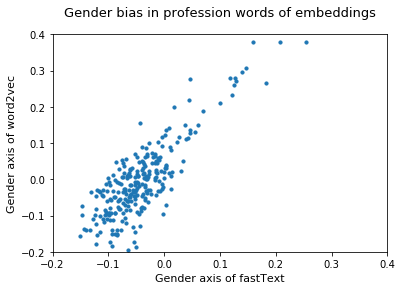

In [12]:
# Plot comparison of bias of word2vec and fastText (or Glove)
fig, ax = plt.subplots()
ax.scatter(compare_datapoints, og_datapoints, s=10)
ax.set_ylim(-0.2, 0.4)
ax.set_xlim(-0.2, 0.4)
plt.xlabel("Gender axis of {}".format(compare_embedding), fontsize=11)
plt.ylabel("Gender axis of word2vec", fontsize=11)
plt.title("Gender bias in profession words of embeddings", pad=18, fontsize=13)
fig.savefig("test.png")
plt.show()

# 3 - Debiasing algorithms on word2vec, Glove and FastText

## Hard debiasing

In hard debiasing, the gender neutral words are shifted to zero in the gender subspace (i.e. neutralized) by subtracting the projection of the neutral word embedding vector onto the gender subspace and renormalizing the resulting embedding to unit length. 

## Soft debiasing

We adapted specifics from Manzini et al., Soft debiasing is done by solving the following optimization problem as mentioned in their paper:

\begin{equation}
    \underset{T}{\min} || (TW)^T(TW) - W^TW||^2_F + \lambda ||(TN)^T (TB)||^2_F
\end{equation}

where W is the matrix of all embedding vectors, N is the matrix of the embedding vectors of the gender neutral words, B is the gender subspace, and T is the debiasing transformation that minimizes the projection of the neutral words onto the gender subspace but tries to maintain the pairwise inner products between the words.

This code is largely based on code from https://github.com/TManzini/DebiasMulticlassWordEmbedding.

In [13]:
# Load gender related word lists from Bolukbasi et al.
with open('./data/definitional_pairs.json', "r") as f:
    defs = json.load(f)

with open('./data/equalize_pairs.json', "r") as f:
    equalize_pairs = json.load(f)

with open('./data/gender_specific_seed.json', "r") as f:
    gender_specific_words = json.load(f)

Please choose one option for debiasing in the following cells.

In [14]:
# TODO 

# Change this to dataset to debias for fastText (E_f) or Glove (E_g). Default is word2vec (E)
E_debias = E

In [15]:
# Hard debias
hard_debias(E, gender_specific_words, defs, equalize_pairs)

# Soft debias
# soft_debias(E, gender_specific_words, defs, log=False)

26423 words of dimension 300 : in, for, that, is, ..., Jay, Leroy, Brad, Jermaine
26423 words of dimension 300 : in, for, that, is, ..., Jay, Leroy, Brad, Jermaine


In [16]:
# TODO

# Save hard debiased embeddings
E.save('./embeddings/w2v_gnews_small_hard_debiased.txt')

# Save soft debiased embeddings
# E.save('./embeddings/w2v_gnews_small_soft_debiased.txt')

Wrote 26423 words to ./embeddings/w2v_gnews_small_hard_debiased.txt


In [17]:
# Analysis of extreme male and extreme female professions
sp_debiased = E.profession_stereotypes(profession_words, v_gender)

                Female                |                 Male                 
-----------------------------------------------------------------------------
0.433                   businesswoman | businessman                    -0.433
0.379                         actress | congressman                    -0.428
0.378                       housewife | dad                            -0.365
0.297                        waitress | councilman                     -0.358
0.272                            maid | statesman                      -0.222
0.265                             nun | salesman                       -0.157
0.261                       ballerina | handyman                       -0.107
0.0                         socialite | monk                           -0.082
0.0                       hairdresser | skipper                          -0.0
0.0                         homemaker | jeweler                          -0.0
0.0                          lecturer | comedian                

In [18]:
# Analogies gender
# a_gender_debiased = E.best_analogies_dist_thresh(v_gender)

# Visualising
# we.viz(a_gender_debiased)

# 4 - Benchmarks

In [19]:
# TODO

def run_benchmark(E, embedding_name):
    benchmark = Benchmark()
    result_original = benchmark.evaluate(E, "'Before', {}".format(embedding_name))
    E_hard = copy.deepcopy(E)
    hard_debias(E_hard, gender_specific_words, defs, equalize_pairs)
    result_hard_debiased = benchmark.evaluate(E_hard, "'Hard debiased', {}".format(embedding_name))
    E_soft = copy.deepcopy(E) 
    soft_debias(E_soft, gender_specific_words, defs, log=False)
    result_soft_debiased = benchmark.evaluate(E, "'Soft debiased', {}".format(embedding_name))
    results = [result_original, result_hard_debiased, result_soft_debiased]
    return results

In [ ]:
# Evaluate for word2vec, Glove and FastText
w2v_results = run_benchmark(E, "word2vec")
g_results = run_benchmark(E_g, "Glove")
f_results = run_benchmark(E_f, "fastText")

benchmark.pprint_compare(w2v_results, ["Before", "Hard-debiased", "Soft-debiased"], "word2vec")
benchmark.pprint_compare(g_results, ["Before", "Hard-debiased", "Soft-debiased"], "Glove")
benchmark.pprint_compare(f_results, ["Before", "Hard-debiased", "Soft-debiased"], "fastText")

+--------------------------------------------------------+
|             Results for 'Before', word2vec             |
+---------------+-------+-----------+--------------------+
| Dataset       | Found | Not Found |       Score        |
+---------------+-------+-----------+--------------------+
| EN-WS-353-ALL |  318  |     35    | 68.52623098234018  |
| EN-RG-65      |   53  |     12    | 77.49622028082247  |
| MSR-analogy   |  5276 |    2724   | 46.967399545109934 |
+---------------+-------+-----------+--------------------+
26423 words of dimension 300 : in, for, that, is, ..., Jay, Leroy, Brad, Jermaine
26423 words of dimension 300 : in, for, that, is, ..., Jay, Leroy, Brad, Jermaine
+-------------------------------------------------------+
|         Results for 'Hard debiased', word2vec         |
+---------------+-------+-----------+-------------------+
| Dataset       | Found | Not Found |       Score       |
+---------------+-------+-----------+-------------------+
| EN-WS-353-ALL